## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a softmax classifier.

In [201]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [202]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '../cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [203]:
from nndl import Softmax

In [204]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [205]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [206]:
print(loss)

2.327760702804897


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

Initially all weights are close to 0 (0.0001) so e^w becomes 1; Sofmax becomes 1/10; and -log(softmax) becomes 2.3. In loss we're taking a mean of for all examples, which are 2.3. Hence the average loss is 2.3  

#### Softmax gradient

In [207]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: 0.394800 analytic: 0.394800, relative error: 3.192154e-08
numerical: -0.559981 analytic: -0.559981, relative error: 8.947427e-10
numerical: -1.673186 analytic: -1.673186, relative error: 1.066596e-08
numerical: 1.881785 analytic: 1.881785, relative error: 3.070772e-10
numerical: 0.921359 analytic: 0.921359, relative error: 3.323017e-08
numerical: 1.654556 analytic: 1.654556, relative error: 5.940917e-09
numerical: -0.069415 analytic: -0.069415, relative error: 2.468808e-07
numerical: -0.658161 analytic: -0.658161, relative error: 4.087038e-09
numerical: 1.061699 analytic: 1.061699, relative error: 2.079294e-08
numerical: -3.228319 analytic: -3.228319, relative error: 1.398503e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [208]:
import time

In [211]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.3312721708461672 / 384.9360658044393 computed in 0.056385040283203125s
Vectorized loss / grad: 2.3312721708461686 / 384.93606580443924 computed in 0.002574920654296875s
difference in loss / grad: -1.3322676295501878e-15 /2.607030649150689e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

## Question:

How should the softmax gradient descent training step differ from the svm training step, if at all?

## Answer:

In SVM, we have a different loss function compared to softmax. So gradient calculation will change but gradient decent will remain same

iteration 0 / 1500: loss 2.3365926606637544
iteration 100 / 1500: loss 2.0557222613850827
iteration 200 / 1500: loss 2.0357745120662813
iteration 300 / 1500: loss 1.9813348165609888
iteration 400 / 1500: loss 1.9583142443981612
iteration 500 / 1500: loss 1.8622653073541355
iteration 600 / 1500: loss 1.853261145435938
iteration 700 / 1500: loss 1.8353062223725827
iteration 800 / 1500: loss 1.829389246882764
iteration 900 / 1500: loss 1.8992158530357484
iteration 1000 / 1500: loss 1.97835035402523
iteration 1100 / 1500: loss 1.8470797913532633
iteration 1200 / 1500: loss 1.8411450268664082
iteration 1300 / 1500: loss 1.7910402495792102
iteration 1400 / 1500: loss 1.8705803029382257
That took 3.5640828609466553s


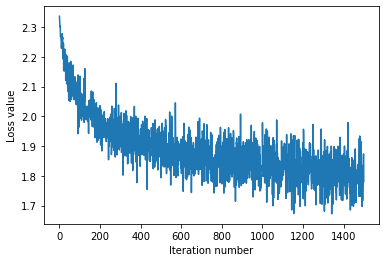

In [212]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [213]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3811428571428571
validation accuracy: 0.398


## Optimize the softmax classifier

You may copy and paste your optimization code from the SVM here.

In [214]:
np.finfo(float).eps

2.220446049250313e-16

That took 5.370471000671387s
training accuracy: 0.15177551020408164
validation accuracy: 0.174


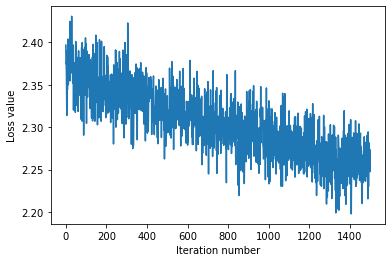

That took 2.529613971710205s
training accuracy: 0.2861020408163265
validation accuracy: 0.303


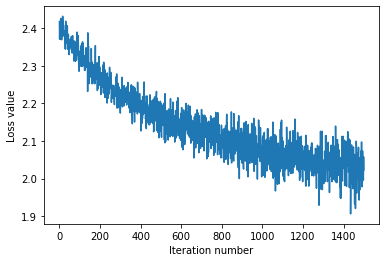

That took 2.3880419731140137s
training accuracy: 0.4126326530612245
validation accuracy: 0.42


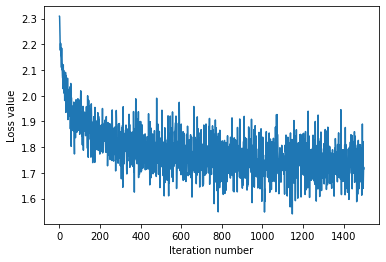

That took 2.314687967300415s
training accuracy: 0.39516326530612245
validation accuracy: 0.399


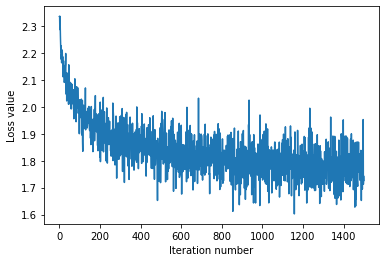

That took 2.2825448513031006s
training accuracy: 0.3826530612244898
validation accuracy: 0.389


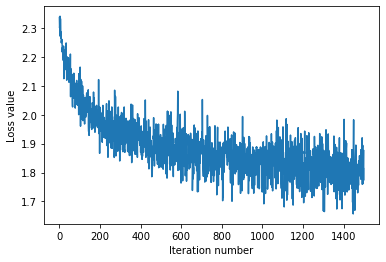

That took 6.018434047698975s
training accuracy: 0.37620408163265306
validation accuracy: 0.354


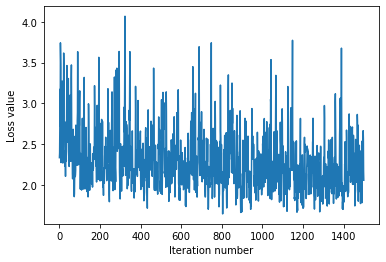

That took 2.9429879188537598s
training accuracy: 0.41459183673469385
validation accuracy: 0.39


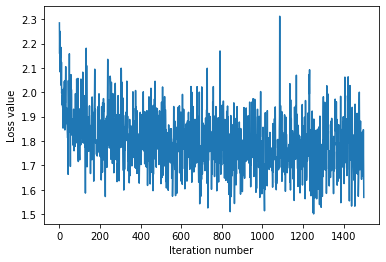

That took 3.5817999839782715s
training accuracy: 0.42136734693877553
validation accuracy: 0.407


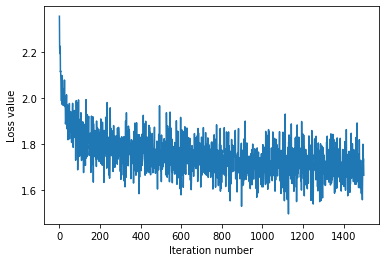

That took 4.134116172790527s
training accuracy: 0.3256734693877551
validation accuracy: 0.306


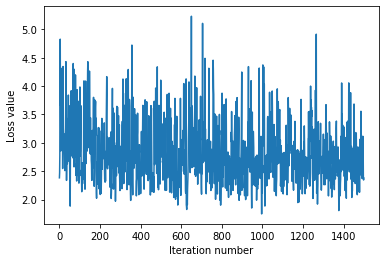

best validation accuracy: 0.42
best validation error: 0.5800000000000001
best learning rate: 5e-07
test accuracy: 0.393
test error: 0.607


In [230]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #

learning_rates = [1e-9, 1e-8, 5e-7, 2e-7, 1e-7, 8e-6, 5e-6, 1e-6, 1e-5]
validation_accuracies = []

for learning_rate in learning_rates:
    tic = time.time()
    loss_hist = softmax.train(X_train, y_train, learning_rate=learning_rate,
                          num_iters=1500, verbose=False)
    toc = time.time()
    print('That took {}s'.format(toc - tic))

    y_train_pred = softmax.predict(X_train)
    print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
    y_val_pred = softmax.predict(X_val)
    print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))
    validation_accuracies.append(np.mean(np.equal(y_val, y_val_pred)))
    
    plt.plot(loss_hist)
    plt.xlabel('Iteration number')
    plt.ylabel('Loss value')
    plt.show()


    
best_learning_rate = learning_rates[np.argmax(validation_accuracies)]
best_validation_accuracy = np.max(validation_accuracies)
print('best validation accuracy: {}'.format(best_validation_accuracy))
print('best validation error: {}'.format(1-best_validation_accuracy))
print('best learning rate: {}'.format(best_learning_rate))    
      
loss_hist = softmax.train(X_train, y_train, learning_rate=best_learning_rate,
                          num_iters=1500, verbose=False)

y_test_pred = softmax.predict(X_test)
print('test accuracy: {}'.format(np.mean(np.equal(y_test, y_test_pred)), ))
print('test error: {}'.format(1-np.mean(np.equal(y_test, y_test_pred)), ))
    

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #
